# Importing Libraries

In [1]:
import os
import cv2
from sklearn.utils import shuffle 
import seaborn as sn; sn.set(font_scale=1.2)
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

# Loading Dataset

In [2]:
class_names = ['Benign cases','Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
def load_data():
  
    datasets = ['train', 'test']
    output = []    
    for dataset in datasets:        
        images = []
        labels = []        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):                
                img_path = os.path.join(os.path.join(dataset, folder), file)                
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE)                 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        
    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|███████████████████████████████████████████████████████████████████████████████| 332/332 [00:02<00:00, 111.27it/s]


Loading test


100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 115.01it/s]


# Shuffle Data 

In [5]:
from sklearn.utils import shuffle 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Exploratory Data Analysis

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 876
Number of testing examples: 221
Each image is of size: (224, 224)


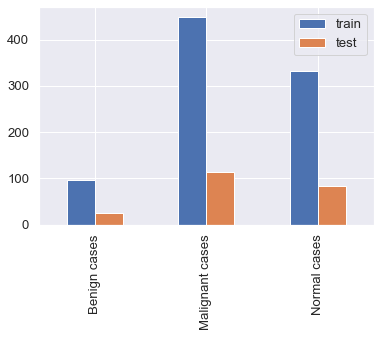

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
              'test': test_counts}, 
             index=class_names).plot.bar()

plt.show()

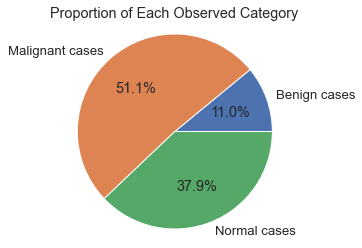

In [8]:
plt.pie(train_counts,
        explode=None, 
        labels=class_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of Each Observed Category')
plt.show()

# Data Preprocessing

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Deep Learning Architecture

# 1. Define Network

In [15]:
import tensorflow as tf 
from tensorflow.keras.utils import plot_model

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               11944064  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

# 2. Compile Network

In [13]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

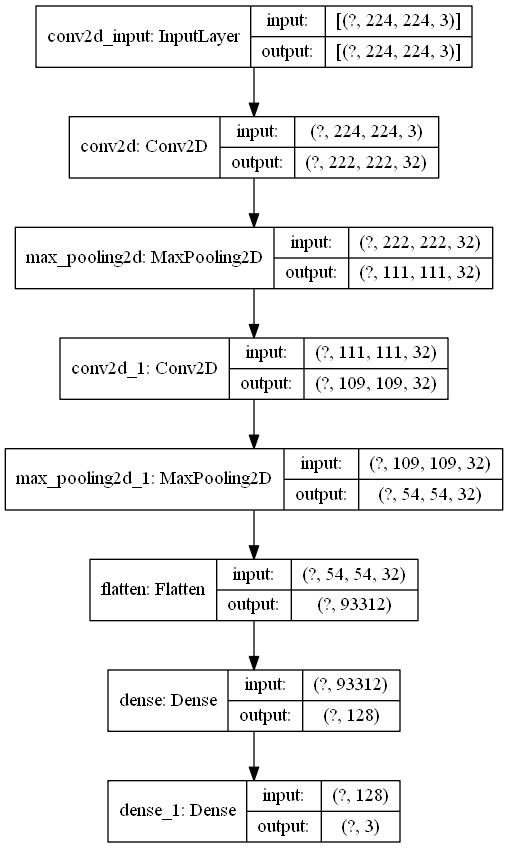

In [16]:
plot_model(model, 'CNN Architecture.jpg', show_shapes = True)

# 3. Fit Network

In [17]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=30, validation_split = 0.2)

Epoch 1/30
11/11 [==============================] - 31s 3s/step - loss: 2.9586 - accuracy: 0.5286 - val_loss: 0.9540 - val_accuracy: 0.5057
Epoch 2/30
11/11 [==============================] - 29s 3s/step - loss: 0.7372 - accuracy: 0.6800 - val_loss: 0.5351 - val_accuracy: 0.8466
Epoch 3/30
11/11 [==============================] - 28s 3s/step - loss: 0.3407 - accuracy: 0.8943 - val_loss: 0.3009 - val_accuracy: 0.8636
Epoch 4/30
11/11 [==============================] - 28s 3s/step - loss: 0.1641 - accuracy: 0.9429 - val_loss: 0.1380 - val_accuracy: 0.9545
Epoch 5/30
11/11 [==============================] - 28s 3s/step - loss: 0.0638 - accuracy: 0.9914 - val_loss: 0.1347 - val_accuracy: 0.9432
Epoch 6/30
11/11 [==============================] - 28s 3s/step - loss: 0.0288 - accuracy: 0.9957 - val_loss: 0.0689 - val_accuracy: 0.9773
Epoch 7/30
11/11 [==============================] - 29s 3s/step - loss: 0.0144 - accuracy: 0.9971 - val_loss: 0.0723 - val_accuracy: 0.9602
Epoch 8/30
11/11 [==

# 4.Evaluate Network

## 4.1. Classification Report

In [18]:
test_loss = model.evaluate(test_images, test_labels)

7/7 [==============================] - 2s 292ms/step - loss: 0.0445 - accuracy: 0.9819


In [19]:
test_loss

[0.04449139162898064, 0.9819004535675049]

In [20]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

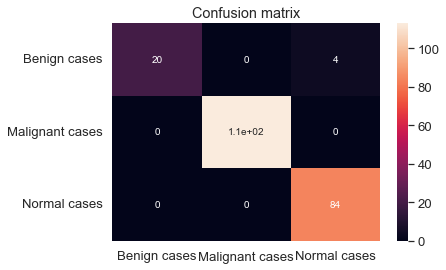

In [21]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [22]:
from sklearn.metrics import classification_report
print('Classification Report')

print(classification_report(test_labels,pred_labels))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       1.00      1.00      1.00       113
           2       0.95      1.00      0.98        84

    accuracy                           0.98       221
   macro avg       0.98      0.94      0.96       221
weighted avg       0.98      0.98      0.98       221



## 4.2. Plotting Loss and Accuracy Curve

Text(0.5, 1.0, 'Accuracy Curves for CNN model')

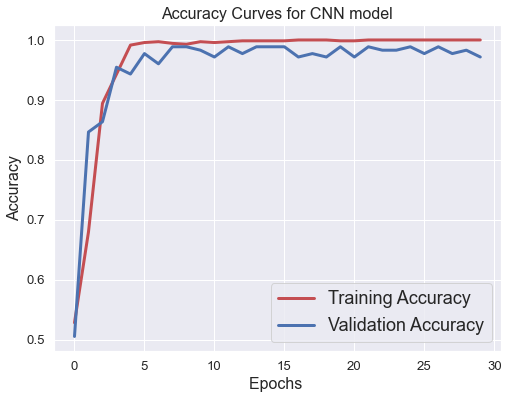

In [23]:
# Accuracy Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['accuracy'],'r',linewidth=3.0)

plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)

plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves for CNN model',fontsize=16)

Text(0.5, 1.0, 'Loss Curves for CNN model')

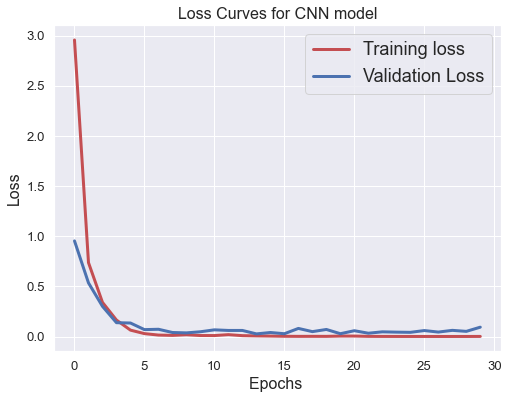

In [24]:
# Loss Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['loss'],'r',linewidth=3.0)

plt.plot(history.history['val_loss'],'b',linewidth=3.0)

plt.legend(['Training loss', 'Validation Loss'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Loss',fontsize=16)

plt.title('Loss Curves for CNN model',fontsize=16)

## 4.3. Evaluation

In [28]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(test_labels,pred_labels))
print('MSE:', metrics.mean_squared_error(test_labels,pred_labels))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels,pred_labels)))

MAE: 0.03619909502262444
MSE: 0.07239819004524888
RMSE: 0.269069117598525


In [29]:
from sklearn.metrics import precision_score
print("Precision Score : ",precision_score(test_labels,pred_labels, average='weighted'))


from sklearn.metrics import recall_score
print("Recall Score : ",recall_score(test_labels,pred_labels,average='weighted'))


from sklearn.metrics import f1_score
print("f1_score : ",f1_score(test_labels,pred_labels,average='weighted'))

Precision Score :  0.9827231591937474
Recall Score :  0.9819004524886877
f1_score :  0.9812882056384108


##  4.4. Make Predictions

In [26]:
preds = model.predict(test_images)

print('shape of preds: ', preds.shape)

shape of preds:  (221, 3)


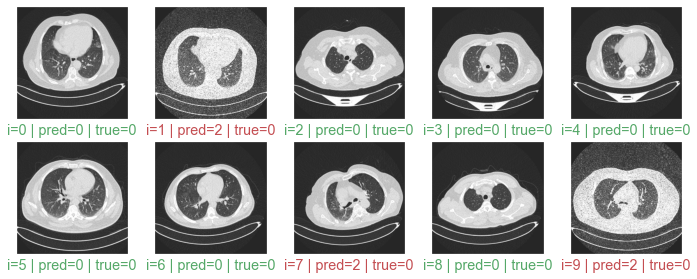

In [30]:
plt.figure(figsize = (12, 12))

start_index = 0

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(test_labels[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(test_images[start_index + i], cmap='binary')
plt.show()